In [18]:
from PIL import Image, ImageOps
import pytesseract
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import os
from os.path import abspath
%matplotlib inline

plt.figure(figsize=(3,3))

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

True

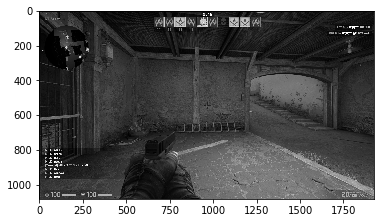

In [566]:
img = cv2.imread('../img/test2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, interpolation='none', cmap='gray')
cv2.imwrite("imgs/base_img.png", gray)

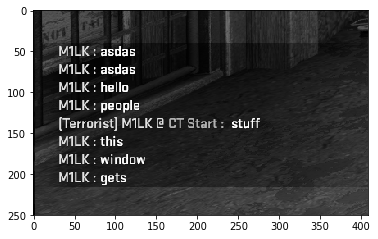

In [567]:
text_area = gray[750:1000, 5:414]
plt.imshow(text_area, interpolation='none', cmap='gray')

## Image Conversion

In [568]:
kernel = np.ones((2,1),np.uint8)
kernel2 = np.ones((5,17),np.uint8)

In [569]:
thr3 = cv2.adaptiveThreshold(text_area,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,37,-70)
eroded = cv2.erode(thr3,kernel,iterations = 1)
dilated = cv2.dilate(eroded,kernel2,iterations = 1)

In [570]:
#Image.fromarray(dilated).show()
extracted = cv2.bitwise_and(text_area,text_area, mask = dilated)
#Image.fromarray(extracted).show()
cv2.imwrite("imgs/extracted.png", extracted)
inverted = cv2.bitwise_not(extracted)
#Image.fromarray(inverted).show()
cv2.imwrite("imgs/inverted.png", inverted)

True

In [571]:
def resize(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    return cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR) 

In [572]:
def brightness_contrast_adjust(img, b, c):
    return cv2.addWeighted(img, 1. + c/127., img, 0, b-c)

In [573]:
_, contours, hierarchy = cv2.findContours(dilated.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
t2 = text_area.copy()
lines = []
for c in contours:
    (x, y, w, h) = cv2.boundingRect(c) #bounding box
    ar = w / float(h) #Aspect ratio
    if ar > 4 and h >10:
        print "height: {}".format(h)
        print "Aspect ratio: {}".format(ar)
        lines.append((y, t2[y:y + h, x:x + w].copy())) #add y value so can sort
        cv2.rectangle(t2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
lines = sorted(lines, key=lambda x: x[0])
lines = map(lambda x: x[1], lines)

cv2.imwrite("imgs/bounds.png",t2)
lines = map(cv2.bitwise_not, lines)
lines = map(lambda x: resize(x, 300), lines)
for i, line in enumerate(lines):
    cv2.imwrite("imgs/line" + str(i) + ".png", line)

height: 19
Aspect ratio: 5.15789473684
height: 15
Aspect ratio: 8.06666666667
height: 15
Aspect ratio: 6.26666666667
height: 21
Aspect ratio: 12.4285714286
height: 19
Aspect ratio: 6.0
height: 15
Aspect ratio: 6.66666666667
height: 15
Aspect ratio: 7.26666666667
height: 15
Aspect ratio: 7.26666666667


In [574]:
for line in lines:
    text = pytesseract.image_to_string(line, lang="eng",  config='-psm 7')
    print(text)
print "#################"

M1LK : asdas
M1LK : asdas
M1LK : hallo
M1LK : people
[Terrorist] M1LK E CT Start: stuff
M1LK : this
M1LK : window
M1LK : gets
#################


In [575]:
open_kernel = np.ones((2,2),np.uint8)

for i, line in enumerate(lines):
    blur = cv2.GaussianBlur(line,(3,3),1)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, \
                             cv2.THRESH_BINARY,13,26)
    #processed_line = resize(thresh, 300)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, open_kernel)
    
    cv2.imwrite("imgs/line_proccessed" + str(i) + ".png", thresh)
    text = pytesseract.image_to_string(thresh, lang="eng",  config='-psm 7')
    print(text)
    


M1LK : asdas
M1LK : asdas
M1LK : hello
M1LK : people
[Terrorist] M1LK [5‘ CT Start: stuff
M1LK : this
M1LK : window
M1LK : gets


In [576]:
contrast = brightness_contrast_adjust(inverted, 0, 100)
#Image.fromarray(contrast).show()
resized = resize(contrast, 300)
cv2.imwrite("imgs/high_contrast_big.png", resized)

text = pytesseract.image_to_string(resized, lang="eng",  config='--psm 4')
print(text)

M1LK : asdas

M1LK : asdas

M1LK : hello

M1LK : people

[Terrorist] M1LK E CT Start: stuff
M1LK : this

M1LK : window

M1LK : gets


In [577]:
second_thresh = cv2.adaptiveThreshold(contrast,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                             cv2.THRESH_BINARY,31,90)
cv2.imwrite("imgs/2nd.png", second_thresh)

True

In [578]:
text = pytesseract.image_to_string(resize(second_thresh,200), lang="eng",  config='--psm=4')
print(text)

M1LK : asdas

M1LK : asdas

M1LK : hellu

M1LK : people

[Terrorist] M1LK E CT Start: stuff
M1LK : this

M1LK : window

M1LK : gets
